In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradients Parcelwise PLS

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include (age and gender added here)
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS', 'age', 'gender']

# ------------------------
# Helper function
# ------------------------
def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df

# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)
        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # ------------------------
    # Combine behavioral + clinical variables (Y)
    # Age and gender are included here
    # ------------------------
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove any subjects with missing data
    # ------------------------
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Standardize (z-score) both X and Y
    # ------------------------
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Saliences (weights) for X and Y
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores (how much each subject expresses the LV pattern)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate each behavioral variable with the LV behavioral score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,
        'Y_std': Y_std
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations (higher = worse severity):
  diagnosis                :  0.786
  SAPSDisorganization      : -0.508
  Amotivation              : -0.561
  DimEx                    : -0.482
  SAPSPositiveSymptoms     : -0.798
  hamilton_21              : -0.155
  YMRS                     : -0.190
  age                      : -0.285
  gender                   :  0.317
  Attention_WorkingMemory  : -0.571
  VerbalLearning_Memory    : -0.604
  Reasoning_ProblemSolving : -0.597
  Verbal_Comprehension     : -0.576

--- Processing G2 ---
G2 behavioral correlations (higher = worse severity):
  diagnosis                :  0.789
  SAPSDisorganization      : -0.475
  Amotivation              : -0.544
  DimEx                    : -0.489
  SAPSPositiveSymptoms     : -0.801
  hamilton_21              : -0.159
  YMRS                     : -0.160
  age                      : -0.203
  gender                   :  0.351
  Attention_WorkingMemory  : -0.592
  VerbalLearning_M

## Cortical projection of loadings

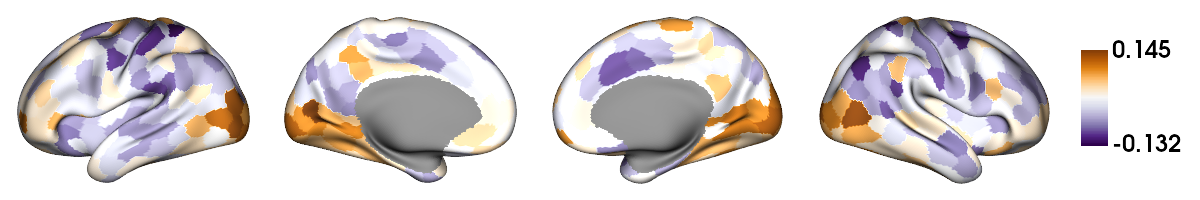

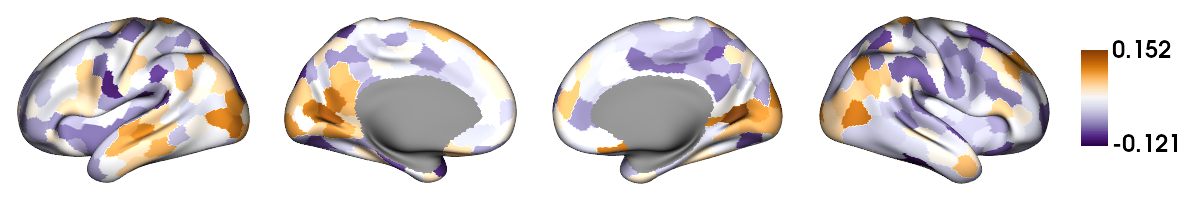

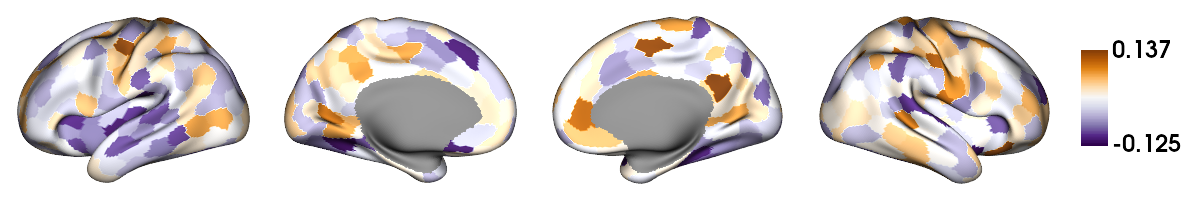

In [18]:
from IPython.display import Image, display
import numpy as np

# Loop through all gradients in the PLS results
for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']  # LV1 only

    # Create brain map with NaNs everywhere except labeled parcels
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j + 1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    # Save filename
    filename = f'./new_figures/{grad_name}_LC1_map_cortex.png'

    # Plot cortical surface (using your custom plotting function `fp.plot_surface`)
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # Save instead of showing interactively
        filename=filename
    )

    # Display the saved image
    display(Image(filename))


## Permutation testing

In [4]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


G1 LV1 permutation p-value: 0.0643
Permutation testing for G2...
G2 LV1 permutation p-value: 0.5890
Permutation testing for G3...
G3 LV1 permutation p-value: 0.8930


## Bootstrap resampling

Bootstrap resampling for G1...


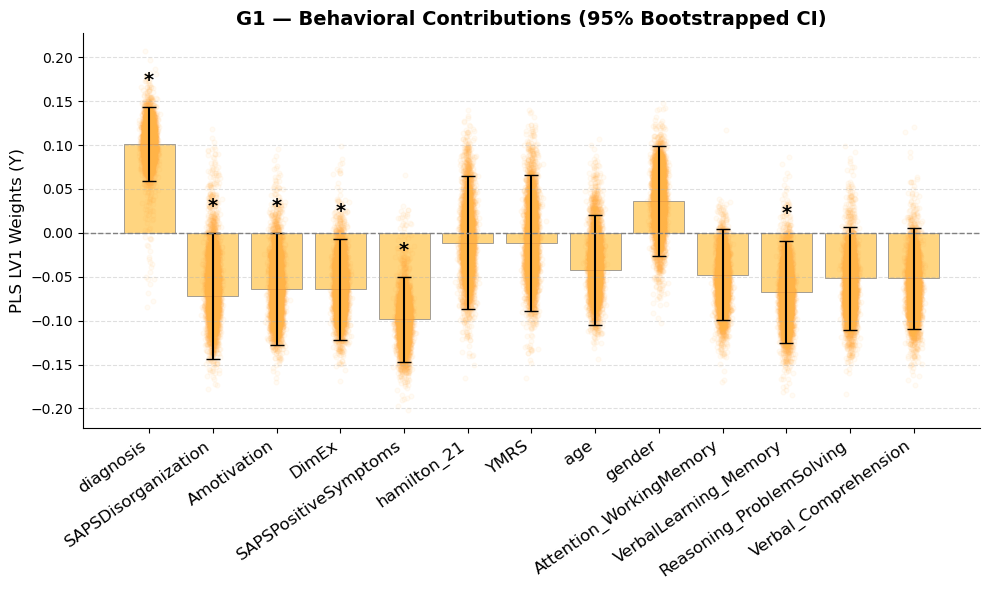

Bootstrap resampling for G2...


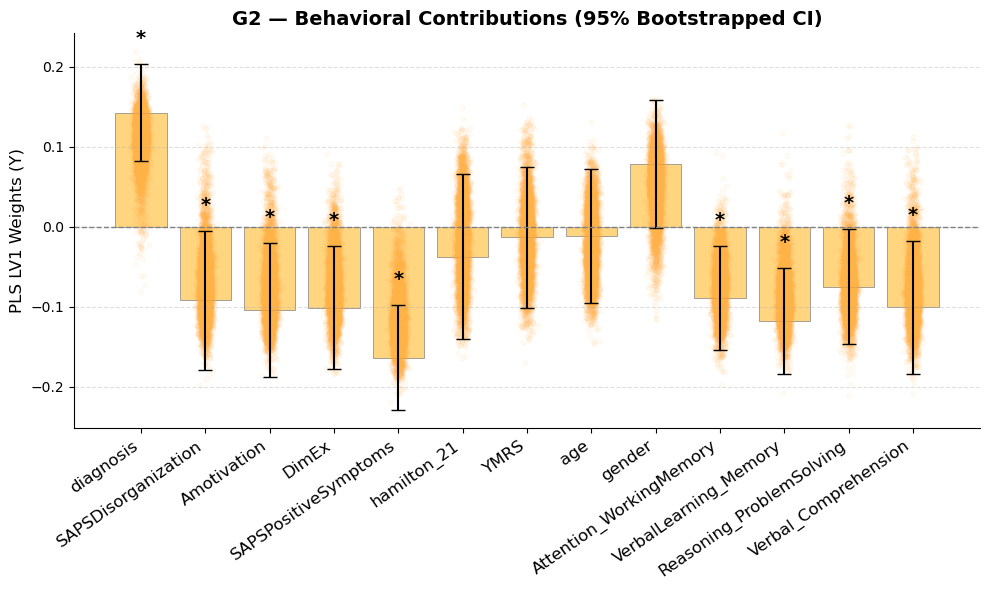

Bootstrap resampling for G3...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


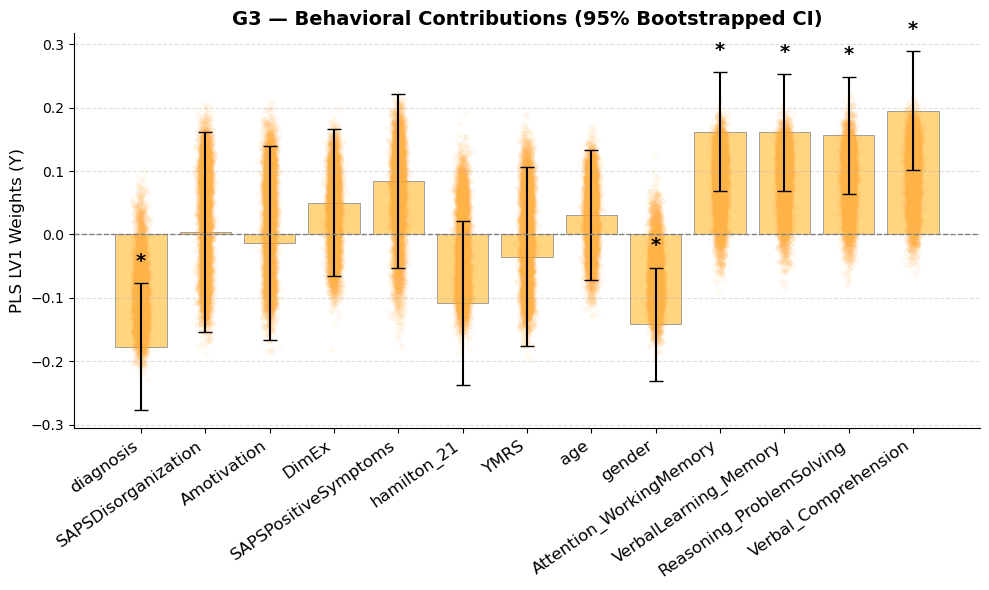

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------

        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1...
  LV1 explains 8.96% of X variance, 9.77% of Y variance, and 13.01% shared variance.

Computing variance explained for G2...
  LV1 explains 5.17% of X variance, 13.13% of Y variance, and 3.75% shared variance.

Computing variance explained for G3...
  LV1 explains 3.63% of X variance, 14.43% of Y variance, and 1.88% shared variance.



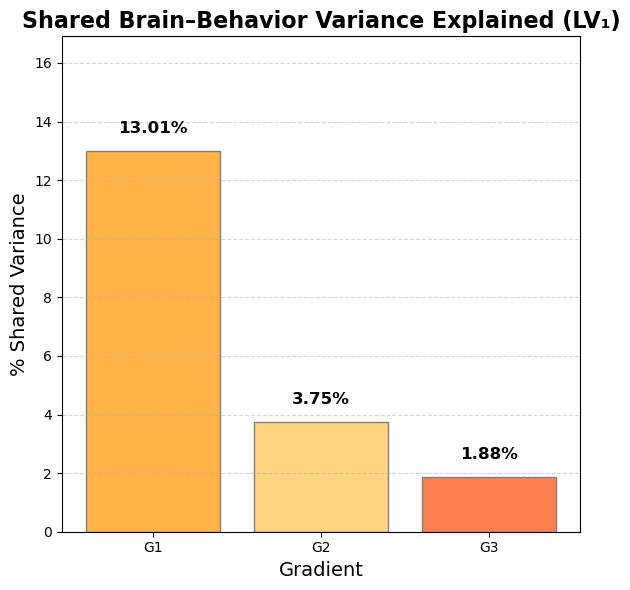

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict = {}

for grad_name, res in results.items():
    print(f"Computing variance explained for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    # Reconstruct predicted X and Y
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained within each block
    var_X = np.var(X, axis=0).sum()
    var_Y = np.var(Y, axis=0).sum()
    var_X_expl = np.var(X_pred, axis=0).sum() / var_X
    var_Y_expl = np.var(Y_pred, axis=0).sum() / var_Y

    # Shared cross-covariance variance explained
    shared_var = (pls.x_scores_.T @ pls.y_scores_)**2 / (np.sum(X**2) * np.sum(Y**2))
    shared_var = shared_var.item() 

    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var'] = shared_var

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared%': shared_var * 100
    }

    print(f"  LV1 explains {var_X_expl * 100:.2f}% of X variance, "
          f"{var_Y_expl * 100:.2f}% of Y variance, "
          f"and {shared_var * 100:.2f}% shared variance.\n")

# --- Plot Shared Variance Explained ---
grad_names = list(var_explained_dict.keys())
vals = [v['Shared%'] for v in var_explained_dict.values()]

plt.figure(figsize=(6, 6))
bars = plt.bar(grad_names, vals, color=['#FFB347', '#FFD580', '#FF7F50'], edgecolor='gray')

for i, v in enumerate(vals):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Shared Brain–Behavior Variance Explained (LV₁)", fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1.png", dpi=300)
plt.show()


## New variance explained

1. Matrix-Based Shared Variance

What it measures:

- Think of the entire X–Y relationship as a big table showing how every brain region covaries with every behavioral score.
- LV₁ gives a partial reconstruction of this table.
- Matrix-based shared variance tells you: “How much of the total pattern of brain–behavior covariance is explained by LV₁?”

Key point:

- It considers all features in X and Y.
- If LV₁ captures only part of the table, the fraction < 100%.

2. Latent-Score–Based Shared Variance

What it measures:

- Instead of looking at all features, it just looks at the summary numbers for each subject: the latent scores t (brain) and u (behavior).
- Then it checks how much these two numbers co-vary.

Analogy: Imagine each subject has a single “brain score” and a single “behavior score” from LV₁. How strongly do these two scores move together across subjects? Latent-score metric = fraction of total covariance energy captured by just this one pair of summary scores.

Key point:

- This is a simpler, lower-dimensional view.
- Usually, it’s ≤ the matrix-based metric, because we’re ignoring all the other details of X and Y.

Computing variance explained for gradients-based PLS across all gradients...

G1:
  LV1 explains 8.96% of X variance, 9.77% of Y variance, 55.62% of total X–Y cross-covariance energy, and t-u squared correlation = 36.09%

G2:
  LV1 explains 5.17% of X variance, 13.13% of Y variance, 49.79% of total X–Y cross-covariance energy, and t-u squared correlation = 48.30%

G3:
  LV1 explains 3.63% of X variance, 14.43% of Y variance, 38.14% of total X–Y cross-covariance energy, and t-u squared correlation = 58.56%



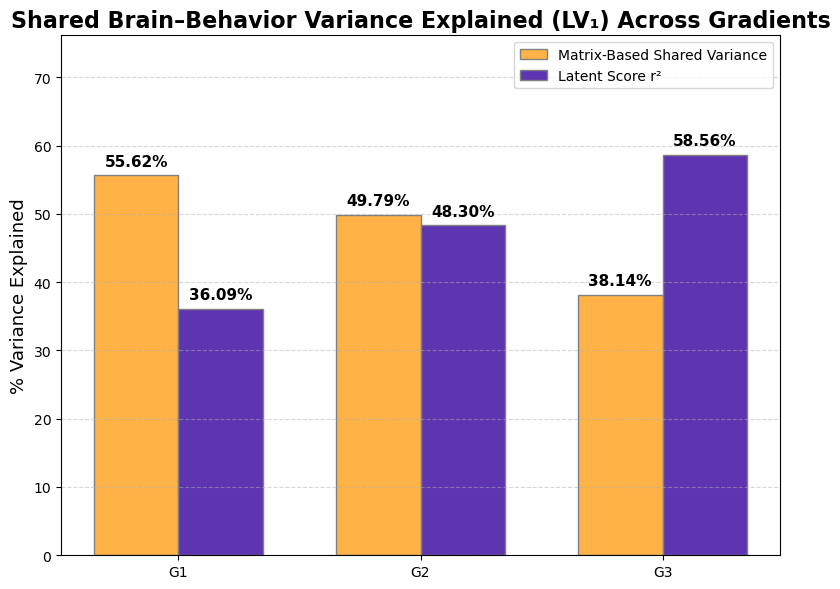

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

var_explained_dict = {}

print("Computing variance explained for gradients-based PLS across all gradients...\n")

for grad_name, res in results.items():

    X = res['X_std']
    Y = res['Y_std']
    n_samples = X.shape[0]

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    var_X_expl = np.sum(X_pred**2) / np.sum(X**2)
    var_Y_expl = np.sum(Y_pred**2) / np.sum(Y**2)

    # Shared variance (matrix-based)
    C_full = (X.T @ Y) / (n_samples - 1)
    C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
    total_cross_energy = np.sum(C_full**2)
    explained_cross_energy = np.sum(C_pred**2)
    shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

    # Latent scores squared correlation
    t = pls.x_scores_[:, 0]
    u = pls.y_scores_[:, 0]
    r2_latent = np.corrcoef(t, u)[0, 1]**2

    # Store results
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var_matrix'] = shared_var_matrix
    res['r2_latent'] = r2_latent

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared_matrix%': shared_var_matrix * 100,
        'r2_latent%': r2_latent * 100
    }

    print(f"{grad_name}:")
    print(f"  LV1 explains {var_X_expl*100:.2f}% of X variance, "
          f"{var_Y_expl*100:.2f}% of Y variance, "
          f"{shared_var_matrix*100:.2f}% of total X–Y cross-covariance energy, "
          f"and t-u squared correlation = {r2_latent*100:.2f}%\n")

# --- Combined plot for all gradients ---
grad_names = list(var_explained_dict.keys())
matrix_vals = [v['Shared_matrix%'] for v in var_explained_dict.values()]
latent_vals = [v['r2_latent%'] for v in var_explained_dict.values()]

x = np.arange(len(grad_names))
width = 0.35  # width of the bars

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, matrix_vals, width, label='Matrix-Based Shared Variance', color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, latent_vals, width, label='Latent Score r²', color='#5E35B1', edgecolor='gray')

# Add value labels
for i in range(len(grad_names)):
    plt.text(x[i] - width/2, matrix_vals[i] + 1, f"{matrix_vals[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, latent_vals[i] + 1, f"{latent_vals[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, grad_names)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁) Across Gradients", fontsize=16, fontweight='bold')
plt.ylim(0, max(max(matrix_vals), max(latent_vals)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.291


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.0270

Cross-validating G2...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.088
  → Cross-validated correlation p-value = 0.3340

Cross-validating G3...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = -0.104


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.7460


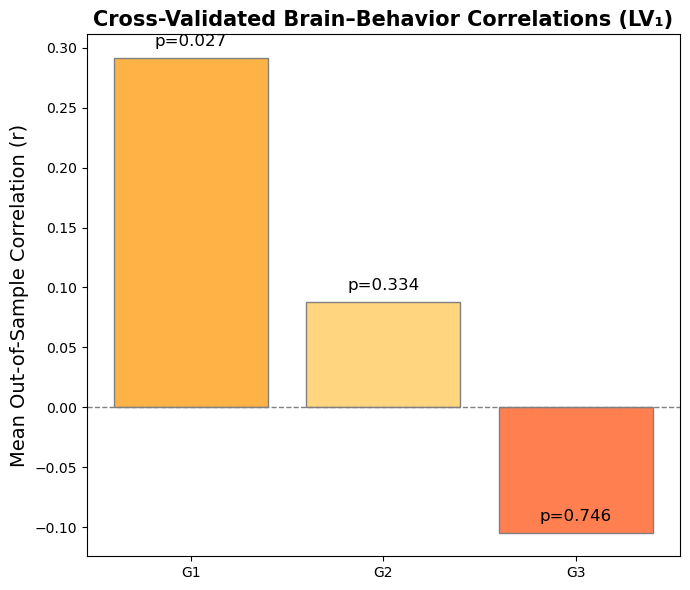

In [8]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS
# --------------------------------------------------
n_splits = 5        # for larger samples
n_repeats = 20      # number of random splits for KFold
n_perm = 1000       # number of permutations
random_state = 42

cv_results = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name, res in results.items():
    print(f"\nCross-validating {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    # Choose CV strategy automatically
    if n < 80:
        print(f"  Small sample detected (n={n}) → using Leave-One-Out CV.")
        use_loocv = True
        n_repeats_eff = 1
    else:
        print(f"  Using {n_splits}-fold CV with {n_repeats} repeats.")
        use_loocv = False
        n_repeats_eff = n_repeats

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred = np.zeros(n)
    all_y_pred = np.zeros(n)

    if use_loocv:
        # LOOCV
        for test_idx in range(n):
            train_idx = np.setdiff1d(np.arange(n), test_idx)
            pls = PLSRegression(n_components=1)
            pls.fit(X[train_idx], Y[train_idx])

            all_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
            all_y_pred[test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred = np.zeros((n_repeats_eff, n))
        temp_y_pred = np.zeros((n_repeats_eff, n))

        for rep in range(n_repeats_eff):
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
            for train_idx, test_idx in kf.split(X):
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y[train_idx])
                temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                temp_y_pred[rep, test_idx] = Y[test_idx] @ pls.y_weights_[:, 0]
        # Average across repeats
        all_x_pred = temp_x_pred.mean(axis=0)
        all_y_pred = temp_y_pred.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r, _ = pearsonr(all_x_pred, all_y_pred)
    print(f"  Observed out-of-sample correlation: r = {observed_r:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs = []
    for perm in range(n_perm):
        Y_perm = Y[np.random.permutation(n)]

        if use_loocv:
            perm_x_pred = np.zeros(n)
            perm_y_pred = np.zeros(n)
            for test_idx in range(n):
                train_idx = np.setdiff1d(np.arange(n), test_idx)
                pls = PLSRegression(n_components=1)
                pls.fit(X[train_idx], Y_perm[train_idx])
                perm_x_pred[test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                perm_y_pred[test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
        else:
            temp_x_pred = np.zeros((n_repeats_eff, n))
            temp_y_pred = np.zeros((n_repeats_eff, n))
            for rep in range(n_repeats_eff):
                kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state + rep)
                for train_idx, test_idx in kf.split(X):
                    pls = PLSRegression(n_components=1)
                    pls.fit(X[train_idx], Y_perm[train_idx])
                    temp_x_pred[rep, test_idx] = X[test_idx] @ pls.x_weights_[:, 0]
                    temp_y_pred[rep, test_idx] = Y_perm[test_idx] @ pls.y_weights_[:, 0]
            perm_x_pred = temp_x_pred.mean(axis=0)
            perm_y_pred = temp_y_pred.mean(axis=0)

        r_perm, _ = pearsonr(perm_x_pred, perm_y_pred)
        perm_corrs.append(r_perm)

    perm_corrs = np.array(perm_corrs)
    pval = np.mean(perm_corrs >= observed_r)

    cv_results[grad_name] = {
        'observed_r': observed_r,
        'perm_corrs': perm_corrs,
        'pval': pval
    }

    print(f"  → Cross-validated correlation p-value = {pval:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars = plt.bar(cv_results.keys(),
               [cv_results[g]['observed_r'] for g in cv_results],
               color=['#FFB347', '#FFD580', '#FF7F50'],
               edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁)", fontsize=15, fontweight='bold')

for i, g in enumerate(cv_results.keys()):
    r = cv_results[g]['observed_r']
    p = cv_results[g]['pval']
    plt.text(i, r + 0.01, f"p={p:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations.png", dpi=300)
plt.show()


## Split half resampling

In [9]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits = 100  # number of random split-half resamplings
stability_results = {}

for grad_name, res in results.items():
    print(f"\nSplit-half resampling for {grad_name}...")

    X = res['X_std']
    Y = res['Y_std']
    n = X.shape[0]

    brain_corrs = []
    behav_corrs = []

    for split in range(n_splits):
        # Random split
        idx = np.random.permutation(n)
        half = n // 2
        idx1, idx2 = idx[:half], idx[half:]

        # PLS on first half
        pls1 = PLSRegression(n_components=1)
        pls1.fit(X[idx1], Y[idx1])
        U1 = pls1.x_weights_[:, 0]
        V1 = pls1.y_weights_[:, 0]

        # PLS on second half
        pls2 = PLSRegression(n_components=1)
        pls2.fit(X[idx2], Y[idx2])
        U2 = pls2.x_weights_[:, 0]
        V2 = pls2.y_weights_[:, 0]

        # Align signs
        if np.dot(U1, U2) < 0:
            U2 *= -1
            V2 *= -1

        # Compute correlation
        brain_corrs.append(np.corrcoef(U1, U2)[0, 1])
        behav_corrs.append(np.corrcoef(V1, V2)[0, 1])

    stability_results[grad_name] = {
        'brain_stability': np.mean(brain_corrs),
        'behav_stability': np.mean(behav_corrs),
        'brain_corrs_all': brain_corrs,
        'behav_corrs_all': behav_corrs
    }

    print(f"  Brain pattern stability (mean r): {stability_results[grad_name]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results[grad_name]['behav_stability']:.3f}")



Split-half resampling for G1...
  Brain pattern stability (mean r): 0.293
  Behavioral pattern stability (mean r): 0.757

Split-half resampling for G2...
  Brain pattern stability (mean r): 0.089
  Behavioral pattern stability (mean r): 0.278

Split-half resampling for G3...
  Brain pattern stability (mean r): 0.094
  Behavioral pattern stability (mean r): -0.220


# PLS without diagnosis 

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files_nodiag = ['./g1_aligned_cog.csv', './g2_aligned_cog.csv', './g3_aligned_cog.csv']
grad_names_nodiag = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions_nodiag = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include (age and gender added here)
other_vars_nodiag = ['SAPSDisorganization', 'Amotivation', 'DimEx',
                     'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS', 'age', 'gender']

# ------------------------
# Helper function
# ------------------------
def ensure_numeric_encoding_nodiag(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df

# ------------------------
# Main analysis
# ------------------------
results_nodiag = {}

for grad_file_nodiag, grad_name_nodiag in zip(grad_files_nodiag, grad_names_nodiag):
    print(f"\n--- Processing {grad_name_nodiag} (no diagnosis) ---")

    # Load gradient file
    df_nodiag = pd.read_csv(grad_file_nodiag)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df_nodiag = df_nodiag[df_nodiag['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    patient_df_nodiag = ensure_numeric_encoding_nodiag(patient_df_nodiag, 'gender')

    # Define parcel columns
    parcel_cols_nodiag = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df_nodiag.columns for col in parcel_cols_nodiag), \
        f"Missing parcel columns in {grad_name_nodiag}"

    X_nodiag = patient_df_nodiag[parcel_cols_nodiag].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name_nodiag, var_list_nodiag in group_definitions_nodiag.items():
        zscored_nodiag = patient_df_nodiag[var_list_nodiag].apply(
            lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score_nodiag = zscored_nodiag.mean(axis=1)

        # Invert so higher = worse
        patient_df_nodiag[group_name_nodiag] = -domain_score_nodiag

    # ------------------------
    # Combine behavioral + clinical variables (Y)
    # Age and gender included here
    # ------------------------
    Y_cols_nodiag = other_vars_nodiag + list(group_definitions_nodiag.keys())
    Y_nodiag = patient_df_nodiag[Y_cols_nodiag].values

    # ------------------------
    # Remove any subjects with missing data in X or Y
    # ------------------------
    valid_mask_nodiag = ~(np.isnan(X_nodiag).any(axis=1) | np.isnan(Y_nodiag).any(axis=1))

    X_valid_nodiag = X_nodiag[valid_mask_nodiag]
    Y_valid_nodiag = Y_nodiag[valid_mask_nodiag]
    patient_df_valid_nodiag = patient_df_nodiag.loc[valid_mask_nodiag].copy()

    # ------------------------
    # Standardize (z-score) both X and Y
    # ------------------------
    X_std_nodiag = StandardScaler().fit_transform(X_valid_nodiag)
    Y_std_nodiag = StandardScaler().fit_transform(Y_valid_nodiag)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls_nodiag = PLSRegression(n_components=1)
    pls_nodiag.fit(X_std_nodiag, Y_std_nodiag)

    # Saliences (weights) for X and Y
    X_saliences_nodiag = pls_nodiag.x_weights_[:, 0]
    Y_saliences_nodiag = pls_nodiag.y_weights_[:, 0]

    # Subject scores
    X_scores_nodiag = pls_nodiag.x_scores_[:, 0]
    Y_scores_nodiag = pls_nodiag.y_scores_[:, 0]

    # Correlate each behavioral variable with LV behavioral score
    behav_corrs_nodiag = {}
    for i, var_nodiag in enumerate(Y_cols_nodiag):
        corr_nodiag, _ = pearsonr(Y_std_nodiag[:, i], Y_scores_nodiag)
        behav_corrs_nodiag[var_nodiag] = corr_nodiag

    # ------------------------
    # Save results
    # ------------------------
    results_nodiag[grad_name_nodiag] = {
        'X_scores': X_scores_nodiag,
        'Y_scores': Y_scores_nodiag,
        'X_saliences': X_saliences_nodiag,
        'Y_saliences': Y_saliences_nodiag,
        'behav_corrs': behav_corrs_nodiag,
        'valid_idx': valid_mask_nodiag,
        'patient_df': patient_df_valid_nodiag,
        'X_std': X_std_nodiag,
        'Y_std': Y_std_nodiag
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name_nodiag} behavioral correlations (higher = worse severity):")
    for var_nodiag, corr_nodiag in behav_corrs_nodiag.items():
        print(f"  {var_nodiag:25s}: {corr_nodiag:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed (no diagnosis). Results stored in `results_nodiag` dict.")



--- Processing G1 (no diagnosis) ---
G1 behavioral correlations (higher = worse severity):
  SAPSDisorganization      : -0.556
  Amotivation              : -0.605
  DimEx                    : -0.465
  SAPSPositiveSymptoms     : -0.753
  hamilton_21              : -0.224
  YMRS                     : -0.274
  age                      : -0.348
  gender                   :  0.311
  Attention_WorkingMemory  : -0.586
  VerbalLearning_Memory    : -0.618
  Reasoning_ProblemSolving : -0.608
  Verbal_Comprehension     : -0.546

--- Processing G2 (no diagnosis) ---
G2 behavioral correlations (higher = worse severity):
  SAPSDisorganization      : -0.526
  Amotivation              : -0.596
  DimEx                    : -0.485
  SAPSPositiveSymptoms     : -0.772
  hamilton_21              : -0.233
  YMRS                     : -0.238
  age                      : -0.244
  gender                   :  0.341
  Attention_WorkingMemory  : -0.604
  VerbalLearning_Memory    : -0.626
  Reasoning_ProblemSolvi

## Cortical projection

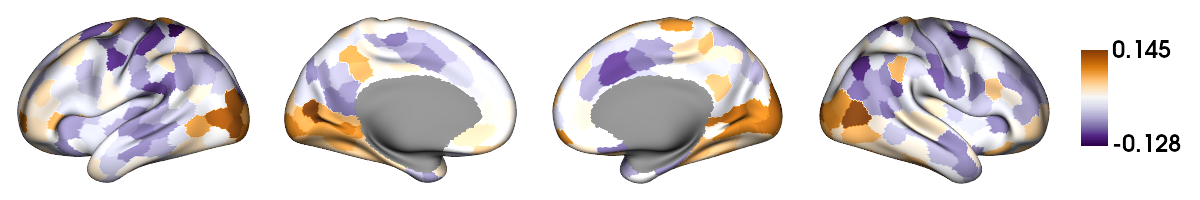

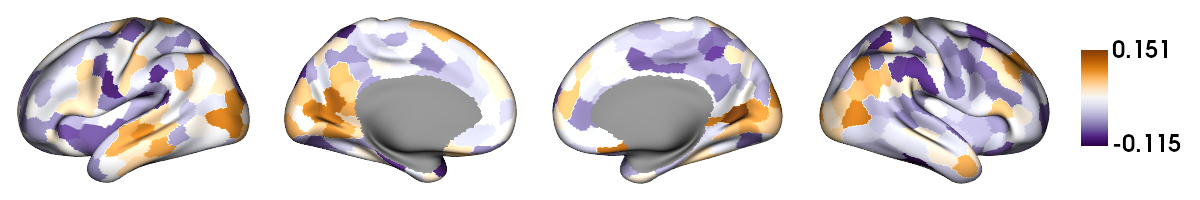

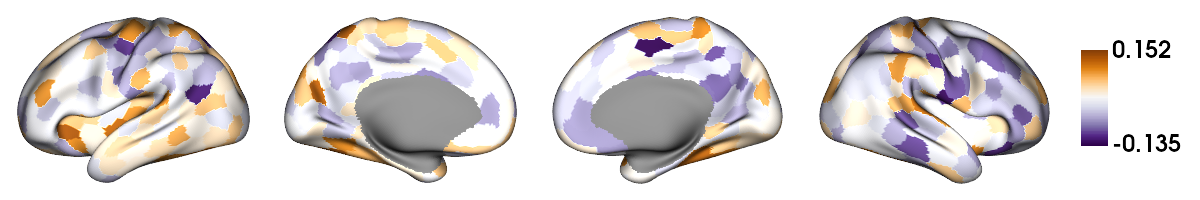

In [19]:
from IPython.display import Image, display
import numpy as np

# Loop through gradients in diagnosis-free PLS results
for grad_name_nodiag in results_nodiag.keys():
    X_saliences_nodiag = results_nodiag[grad_name_nodiag]['X_saliences']
    
    # Create brain map with NaNs everywhere except labeled parcels
    brain_map_nodiag = np.full_like(atlas, np.nan, dtype=float)
    for j_nodiag in range(len(X_saliences_nodiag)):
        brain_map_nodiag[atlas == j_nodiag + 1] = X_saliences_nodiag[j_nodiag]
    brain_map_nodiag[atlas == 0] = np.nan

    # Save filename (unique for nodiag version)
    filename_nodiag = f'./new_figures/{grad_name_nodiag}_LC1_map_cortex_nodiag.png'

    # Plot cortical surface (using your custom plotting function `fp.plot_surface`)
    fp.plot_surface(
        data=[brain_map_nodiag],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # Save instead of showing interactively
        filename=filename_nodiag
    )

    # Display the saved image
    display(Image(filename_nodiag))


## Permutation testing

In [12]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters (no diagnosis)
# -------------------------------
n_permutations_nodiag = 10000  # number of permutations
n_components_nodiag = 1        # LV1 only
results_perm_nodiag = {}       # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name_nodiag in results_nodiag.keys():
    print(f"Permutation testing for {grad_name_nodiag} (no diagnosis)...")

    # Retrieve standardized X and Y
    X_nodiag = results_nodiag[grad_name_nodiag]['X_std']  # standardized X (brain data)
    Y_nodiag = results_nodiag[grad_name_nodiag]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls_nodiag = PLSRegression(n_components=n_components_nodiag)
    pls_nodiag.fit(X_nodiag, Y_nodiag)

    # Observed covariance for LV1
    X_scores_nodiag = pls_nodiag.x_scores_[:, 0]
    Y_scores_nodiag = pls_nodiag.y_scores_[:, 0]
    obs_singular_value_nodiag = np.cov(X_scores_nodiag, Y_scores_nodiag, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values_nodiag = np.zeros(n_permutations_nodiag)
    for i_nodiag in range(n_permutations_nodiag):
        # Shuffle rows of X
        X_perm_nodiag = X_nodiag[np.random.permutation(X_nodiag.shape[0]), :]
        pls_perm_nodiag = PLSRegression(n_components=n_components_nodiag)
        pls_perm_nodiag.fit(X_perm_nodiag, Y_nodiag)

        # Compute covariance for LV1
        X_scores_perm_nodiag = pls_perm_nodiag.x_scores_[:, 0]
        Y_scores_perm_nodiag = pls_perm_nodiag.y_scores_[:, 0]
        perm_singular_values_nodiag[i_nodiag] = np.cov(
            X_scores_perm_nodiag, Y_scores_perm_nodiag, bias=True
        )[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value_nodiag = np.mean(perm_singular_values_nodiag >= obs_singular_value_nodiag)

    # Store results
    results_perm_nodiag[grad_name_nodiag] = {
        'obs_singular_value': obs_singular_value_nodiag,
        'perm_singular_values': perm_singular_values_nodiag,
        'p_value': p_value_nodiag
    }

    print(f"{grad_name_nodiag} LV1 permutation p-value (no diagnosis): {p_value_nodiag:.4f}")


Permutation testing for G1 (no diagnosis)...
G1 LV1 permutation p-value (no diagnosis): 0.1141
Permutation testing for G2 (no diagnosis)...
G2 LV1 permutation p-value (no diagnosis): 0.6562
Permutation testing for G3 (no diagnosis)...
G3 LV1 permutation p-value (no diagnosis): 0.7813


## Bootstrap resampling

Bootstrap resampling for G1 (no diagnosis)...


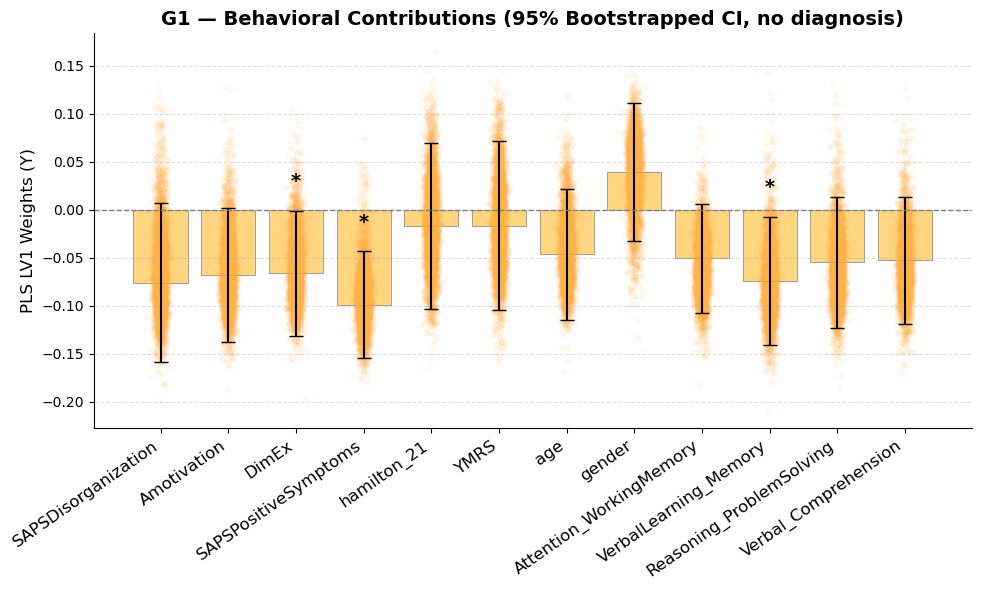

Bootstrap resampling for G2 (no diagnosis)...


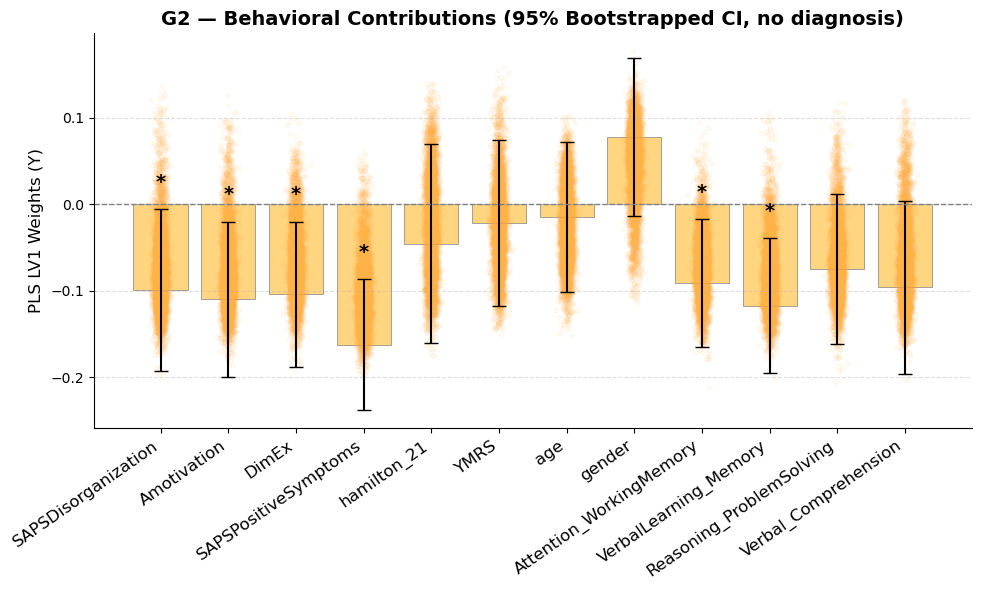

Bootstrap resampling for G3 (no diagnosis)...


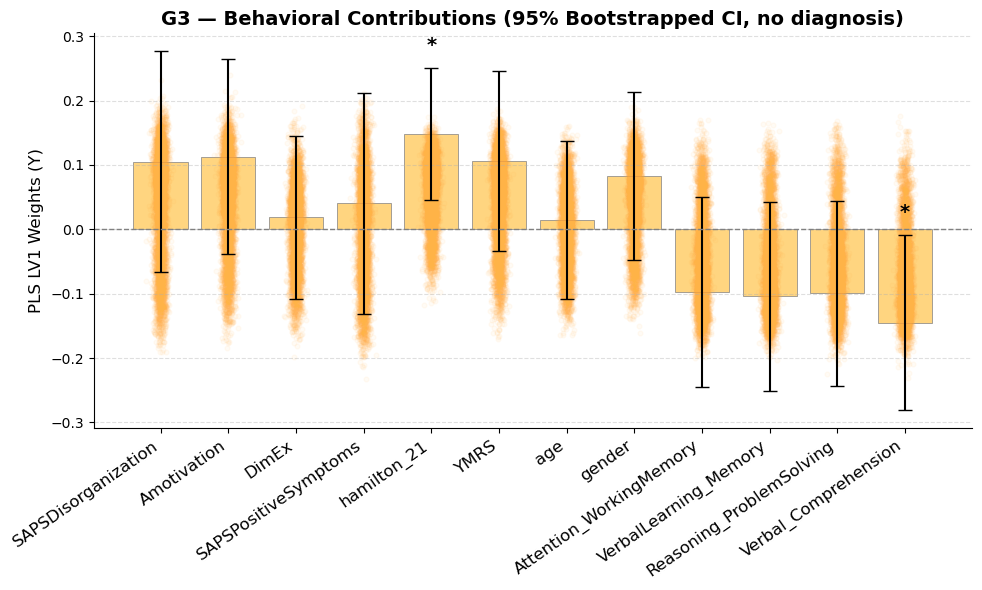

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters (no diagnosis)
# -------------------------------
n_bootstrap_nodiag = 5000   # number of bootstrap resamples
n_components_nodiag = 1     # LV1 only
results_boot_nodiag = {}    # store bootstrap ratios

# Color palette for plotting
bar_color_nodiag = '#FFD580'
point_color_nodiag = '#FFB347'
star_color_nodiag = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name_nodiag, res_nodiag in results_nodiag.items():
    print(f"Bootstrap resampling for {grad_name_nodiag} (no diagnosis)...")

    # Standardized X and Y
    X_nodiag = res_nodiag['X_std']
    Y_nodiag = res_nodiag['Y_std']
    n_subjects_nodiag, n_voxels_nodiag = X_nodiag.shape
    n_behav_nodiag = Y_nodiag.shape[1]

    # Original PLS to get original weights
    pls_orig_nodiag = PLSRegression(n_components=n_components_nodiag)
    pls_orig_nodiag.fit(X_nodiag, Y_nodiag)
    X_orig_weights_nodiag = pls_orig_nodiag.x_weights_[:, 0]
    Y_orig_weights_nodiag = pls_orig_nodiag.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights_nodiag = np.zeros((n_bootstrap_nodiag, n_voxels_nodiag))
    Y_boot_weights_nodiag = np.zeros((n_bootstrap_nodiag, n_behav_nodiag))

    for i_nodiag in range(n_bootstrap_nodiag):
        # Resample subjects with replacement
        Xb_nodiag, Yb_nodiag = resample(X_nodiag, Y_nodiag, 
                                        n_samples=n_subjects_nodiag, replace=True)

        pls_boot_nodiag = PLSRegression(n_components=n_components_nodiag)
        pls_boot_nodiag.fit(Xb_nodiag, Yb_nodiag)
        Xb_weights_nodiag = pls_boot_nodiag.x_weights_[:, 0]
        Yb_weights_nodiag = pls_boot_nodiag.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------
        if np.dot(Xb_weights_nodiag, X_orig_weights_nodiag) < 0:
            Xb_weights_nodiag *= -1
            Yb_weights_nodiag *= -1

        X_boot_weights_nodiag[i_nodiag, :] = Xb_weights_nodiag
        Y_boot_weights_nodiag[i_nodiag, :] = Yb_weights_nodiag

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr_nodiag = X_orig_weights_nodiag / X_boot_weights_nodiag.std(axis=0)
    Y_bsr_nodiag = Y_orig_weights_nodiag / Y_boot_weights_nodiag.std(axis=0)

    results_boot_nodiag[grad_name_nodiag] = {
        'X_bsr': X_bsr_nodiag,
        'Y_bsr': Y_bsr_nodiag,
        'X_boot_weights': X_boot_weights_nodiag,
        'Y_boot_weights': Y_boot_weights_nodiag
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    y_mean_nodiag = Y_orig_weights_nodiag
    y_sd_nodiag = Y_boot_weights_nodiag.std(axis=0)
    lower_ci_nodiag = y_mean_nodiag - 1.96 * y_sd_nodiag
    upper_ci_nodiag = y_mean_nodiag + 1.96 * y_sd_nodiag

    # Determine significance
    significant_nodiag = (lower_ci_nodiag > 0) | (upper_ci_nodiag < 0)

    Y_cols_nodiag = list(res_nodiag['behav_corrs'].keys())
    fig_nodiag, ax_nodiag = plt.subplots(figsize=(10, 6))

    # Bars with error bars
    bars_nodiag = ax_nodiag.bar(
        np.arange(n_behav_nodiag), y_mean_nodiag,
        width=0.8,
        yerr=[y_mean_nodiag - lower_ci_nodiag, upper_ci_nodiag - y_mean_nodiag],
        capsize=5,
        color=bar_color_nodiag,
        edgecolor='gray',
        linewidth=0.5
    )

    # Overlay bootstrap points
    for j_nodiag in range(n_behav_nodiag):
        x_jitter_nodiag = np.random.normal(j_nodiag, 0.05, size=n_bootstrap_nodiag)
        ax_nodiag.scatter(x_jitter_nodiag, Y_boot_weights_nodiag[:, j_nodiag],
                          color=point_color_nodiag, alpha=0.05, s=12)

    # Zero line
    ax_nodiag.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j_nodiag, sig_nodiag in enumerate(significant_nodiag):
        if sig_nodiag:
            ax_nodiag.text(j_nodiag, upper_ci_nodiag[j_nodiag] + 0.02, "*",
                           ha='center', va='bottom',
                           fontsize=14, color=star_color_nodiag, fontweight='bold')

    # Labels
    ax_nodiag.set_xticks(np.arange(n_behav_nodiag))
    ax_nodiag.set_xticklabels(Y_cols_nodiag, rotation=35, ha='right', fontsize=12)
    ax_nodiag.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax_nodiag.set_title(
        f'{grad_name_nodiag} — Behavioral Contributions (95% Bootstrapped CI, no diagnosis)',
        fontsize=14, fontweight='bold'
    )

    ax_nodiag.spines['top'].set_visible(False)
    ax_nodiag.spines['right'].set_visible(False)
    ax_nodiag.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax_nodiag.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for G1 (no diagnosis)...
  LV1 explains 8.92% of X variance, 8.89% of Y variance, and 13.07% shared variance.

Computing variance explained for G2 (no diagnosis)...
  LV1 explains 5.14% of X variance, 12.10% of Y variance, and 4.02% shared variance.

Computing variance explained for G3 (no diagnosis)...
  LV1 explains 3.96% of X variance, 11.66% of Y variance, and 2.95% shared variance.



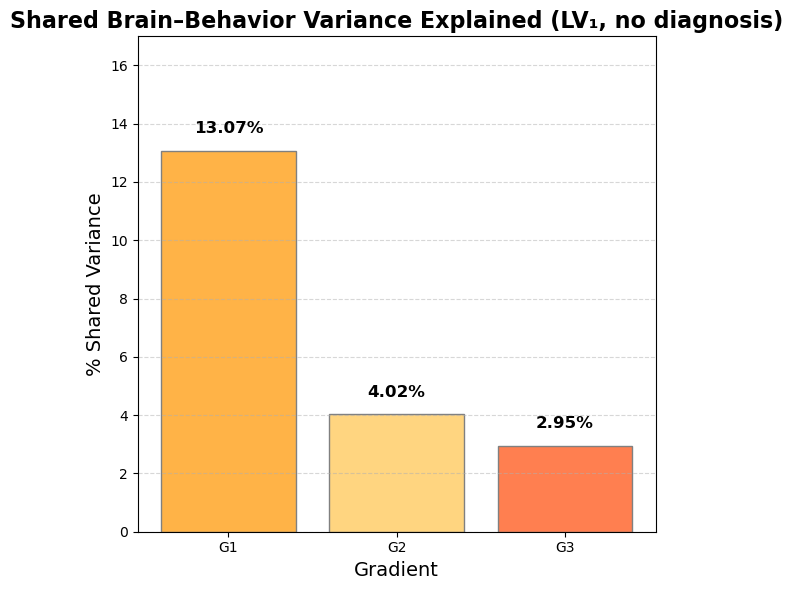

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

var_explained_dict_nodiag = {}

for grad_name_nodiag, res_nodiag in results_nodiag.items():
    print(f"Computing variance explained for {grad_name_nodiag} (no diagnosis)...")

    X_nodiag = res_nodiag['X_std']
    Y_nodiag = res_nodiag['Y_std']

    pls_nodiag = PLSRegression(n_components=1)
    pls_nodiag.fit(X_nodiag, Y_nodiag)

    # Reconstruct predicted X and Y
    X_pred_nodiag = pls_nodiag.x_scores_ @ pls_nodiag.x_loadings_.T
    Y_pred_nodiag = pls_nodiag.x_scores_ @ pls_nodiag.y_loadings_.T

    # Variance explained within each block
    var_X_nodiag = np.var(X_nodiag, axis=0).sum()
    var_Y_nodiag = np.var(Y_nodiag, axis=0).sum()
    var_X_expl_nodiag = np.var(X_pred_nodiag, axis=0).sum() / var_X_nodiag
    var_Y_expl_nodiag = np.var(Y_pred_nodiag, axis=0).sum() / var_Y_nodiag

    # Shared cross-covariance variance explained
    shared_var_nodiag = (pls_nodiag.x_scores_.T @ pls_nodiag.y_scores_)**2 / (
        np.sum(X_nodiag**2) * np.sum(Y_nodiag**2)
    )
    shared_var_nodiag = shared_var_nodiag.item()

    res_nodiag['var_X_expl'] = var_X_expl_nodiag
    res_nodiag['var_Y_expl'] = var_Y_expl_nodiag
    res_nodiag['shared_var'] = shared_var_nodiag

    var_explained_dict_nodiag[grad_name_nodiag] = {
        'X_var%': var_X_expl_nodiag * 100,
        'Y_var%': var_Y_expl_nodiag * 100,
        'Shared%': shared_var_nodiag * 100
    }

    print(
        f"  LV1 explains {var_X_expl_nodiag * 100:.2f}% of X variance, "
        f"{var_Y_expl_nodiag * 100:.2f}% of Y variance, "
        f"and {shared_var_nodiag * 100:.2f}% shared variance.\n"
    )

# --- Plot Shared Variance Explained ---
grad_names_nodiag = list(var_explained_dict_nodiag.keys())
vals_nodiag = [v['Shared%'] for v in var_explained_dict_nodiag.values()]

plt.figure(figsize=(6, 6))
bars_nodiag = plt.bar(
    grad_names_nodiag,
    vals_nodiag,
    color=['#FFB347', '#FFD580', '#FF7F50'],
    edgecolor='gray'
)

for i_nodiag, v_nodiag in enumerate(vals_nodiag):
    plt.text(
        i_nodiag,
        v_nodiag + 0.5,
        f"{v_nodiag:.2f}%",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Shared Brain–Behavior Variance Explained (LV₁, no diagnosis)",
          fontsize=16, fontweight='bold')
plt.ylabel("% Shared Variance", fontsize=14)
plt.xlabel("Gradient", fontsize=14)
plt.ylim(0, max(vals_nodiag) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("new_figures/shared_variance_explained_LV1_nodiag.png", dpi=300)
plt.show()


## New variance explained

Computing variance explained for gradients-based PLS across all gradients (no diagnosis)...

G1:
  LV1 explains 8.92% of X variance, 8.89% of Y variance, 52.18% of total X–Y cross-covariance energy, and t-u squared correlation = 35.03%

G2:
  LV1 explains 5.14% of X variance, 12.10% of Y variance, 45.68% of total X–Y cross-covariance energy, and t-u squared correlation = 48.24%

G3:
  LV1 explains 3.96% of X variance, 11.66% of Y variance, 33.67% of total X–Y cross-covariance energy, and t-u squared correlation = 62.97%



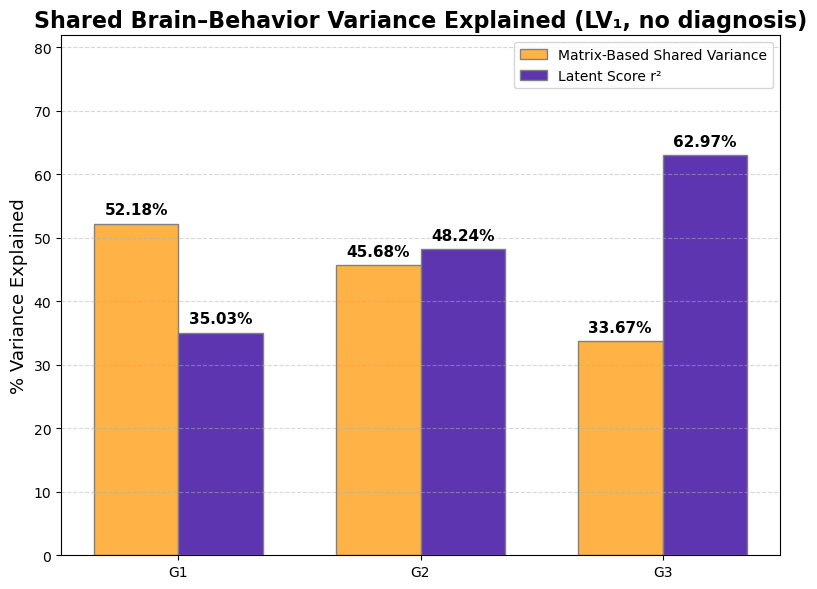

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

var_explained_dict_nodiag = {}

print("Computing variance explained for gradients-based PLS across all gradients (no diagnosis)...\n")

for grad_name_nodiag, res_nodiag in results_nodiag.items():

    X_nodiag = res_nodiag['X_std']
    Y_nodiag = res_nodiag['Y_std']
    n_samples_nodiag = X_nodiag.shape[0]

    pls_nodiag = PLSRegression(n_components=1)
    pls_nodiag.fit(X_nodiag, Y_nodiag)

    X_pred_nodiag = pls_nodiag.x_scores_ @ pls_nodiag.x_loadings_.T
    Y_pred_nodiag = pls_nodiag.x_scores_ @ pls_nodiag.y_loadings_.T

    var_X_expl_nodiag = np.sum(X_pred_nodiag**2) / np.sum(X_nodiag**2)
    var_Y_expl_nodiag = np.sum(Y_pred_nodiag**2) / np.sum(Y_nodiag**2)

    # Shared variance (matrix-based)
    C_full_nodiag = (X_nodiag.T @ Y_nodiag) / (n_samples_nodiag - 1)
    C_pred_nodiag = (X_pred_nodiag.T @ Y_pred_nodiag) / (n_samples_nodiag - 1)
    total_cross_energy_nodiag = np.sum(C_full_nodiag**2)
    explained_cross_energy_nodiag = np.sum(C_pred_nodiag**2)
    shared_var_matrix_nodiag = 0.0 if total_cross_energy_nodiag == 0 else explained_cross_energy_nodiag / total_cross_energy_nodiag

    # Latent scores squared correlation
    t_nodiag = pls_nodiag.x_scores_[:, 0]
    u_nodiag = pls_nodiag.y_scores_[:, 0]
    r2_latent_nodiag = np.corrcoef(t_nodiag, u_nodiag)[0, 1]**2

    # Store results
    res_nodiag['var_X_expl'] = var_X_expl_nodiag
    res_nodiag['var_Y_expl'] = var_Y_expl_nodiag
    res_nodiag['shared_var_matrix'] = shared_var_matrix_nodiag
    res_nodiag['r2_latent'] = r2_latent_nodiag

    var_explained_dict_nodiag[grad_name_nodiag] = {
        'X_var%': var_X_expl_nodiag * 100,
        'Y_var%': var_Y_expl_nodiag * 100,
        'Shared_matrix%': shared_var_matrix_nodiag * 100,
        'r2_latent%': r2_latent_nodiag * 100
    }

    print(f"{grad_name_nodiag}:")
    print(f"  LV1 explains {var_X_expl_nodiag*100:.2f}% of X variance, "
          f"{var_Y_expl_nodiag*100:.2f}% of Y variance, "
          f"{shared_var_matrix_nodiag*100:.2f}% of total X–Y cross-covariance energy, "
          f"and t-u squared correlation = {r2_latent_nodiag*100:.2f}%\n")

# --- Combined plot for all gradients ---
grad_names_nodiag = list(var_explained_dict_nodiag.keys())
matrix_vals_nodiag = [v['Shared_matrix%'] for v in var_explained_dict_nodiag.values()]
latent_vals_nodiag = [v['r2_latent%'] for v in var_explained_dict_nodiag.values()]

x_nodiag = np.arange(len(grad_names_nodiag))
width_nodiag = 0.35  # width of the bars

plt.figure(figsize=(8, 6))
plt.bar(x_nodiag - width_nodiag/2, matrix_vals_nodiag, width_nodiag,
        label='Matrix-Based Shared Variance', color='#FFB347', edgecolor='gray')
plt.bar(x_nodiag + width_nodiag/2, latent_vals_nodiag, width_nodiag,
        label='Latent Score r²', color='#5E35B1', edgecolor='gray')

# Add value labels
for i_nodiag in range(len(grad_names_nodiag)):
    plt.text(x_nodiag[i_nodiag] - width_nodiag/2, matrix_vals_nodiag[i_nodiag] + 1,
             f"{matrix_vals_nodiag[i_nodiag]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x_nodiag[i_nodiag] + width_nodiag/2, latent_vals_nodiag[i_nodiag] + 1,
             f"{latent_vals_nodiag[i_nodiag]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x_nodiag, grad_names_nodiag)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁, no diagnosis)", fontsize=16, fontweight='bold')
plt.ylim(0, max(max(matrix_vals_nodiag), max(latent_vals_nodiag)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1_nodiag.png", dpi=300)
plt.show()


## Cross validation


Cross-validating G1 (no diagnosis)...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.251


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.0610

Cross-validating G2 (no diagnosis)...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = 0.056


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\U

  → Cross-validated correlation p-value = 0.4310

Cross-validating G3 (no diagnosis)...
  Small sample detected (n=73) → using Leave-One-Out CV.
  Observed out-of-sample correlation: r = -0.081


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


  → Cross-validated correlation p-value = 0.6980


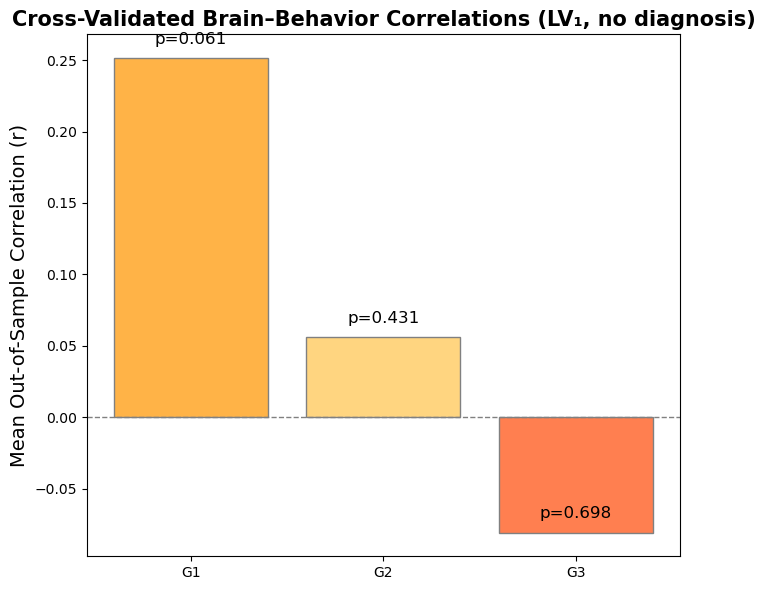

In [16]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# --------------------------------------------------
# PARAMETERS (no diagnosis version)
# --------------------------------------------------
n_splits_nodiag = 5        # for larger samples
n_repeats_nodiag = 20      # number of random splits for KFold
n_perm_nodiag = 1000       # number of permutations
random_state_nodiag = 42

cv_results_nodiag = {}

# --------------------------------------------------
# CROSS-VALIDATION LOOP
# --------------------------------------------------
for grad_name_nodiag, res_nodiag in results_nodiag.items():
    print(f"\nCross-validating {grad_name_nodiag} (no diagnosis)...")

    X_nodiag = res_nodiag['X_std']
    Y_nodiag = res_nodiag['Y_std']
    n_nodiag = X_nodiag.shape[0]

    # Choose CV strategy automatically
    if n_nodiag < 80:
        print(f"  Small sample detected (n={n_nodiag}) → using Leave-One-Out CV.")
        use_loocv_nodiag = True
        n_repeats_eff_nodiag = 1
    else:
        print(f"  Using {n_splits_nodiag}-fold CV with {n_repeats_nodiag} repeats.")
        use_loocv_nodiag = False
        n_repeats_eff_nodiag = n_repeats_nodiag

    # ---------------------------
    # Collect predicted scores
    # ---------------------------
    all_x_pred_nodiag = np.zeros(n_nodiag)
    all_y_pred_nodiag = np.zeros(n_nodiag)

    if use_loocv_nodiag:
        # LOOCV
        for test_idx_nodiag in range(n_nodiag):
            train_idx_nodiag = np.setdiff1d(np.arange(n_nodiag), test_idx_nodiag)
            pls_nodiag = PLSRegression(n_components=1)
            pls_nodiag.fit(X_nodiag[train_idx_nodiag], Y_nodiag[train_idx_nodiag])

            all_x_pred_nodiag[test_idx_nodiag] = X_nodiag[test_idx_nodiag] @ pls_nodiag.x_weights_[:, 0]
            all_y_pred_nodiag[test_idx_nodiag] = Y_nodiag[test_idx_nodiag] @ pls_nodiag.y_weights_[:, 0]
    else:
        # KFold repeated CV
        temp_x_pred_nodiag = np.zeros((n_repeats_eff_nodiag, n_nodiag))
        temp_y_pred_nodiag = np.zeros((n_repeats_eff_nodiag, n_nodiag))

        for rep_nodiag in range(n_repeats_eff_nodiag):
            kf_nodiag = KFold(n_splits=n_splits_nodiag, shuffle=True, random_state=random_state_nodiag + rep_nodiag)
            for train_idx_nodiag, test_idx_nodiag in kf_nodiag.split(X_nodiag):
                pls_nodiag = PLSRegression(n_components=1)
                pls_nodiag.fit(X_nodiag[train_idx_nodiag], Y_nodiag[train_idx_nodiag])
                temp_x_pred_nodiag[rep_nodiag, test_idx_nodiag] = X_nodiag[test_idx_nodiag] @ pls_nodiag.x_weights_[:, 0]
                temp_y_pred_nodiag[rep_nodiag, test_idx_nodiag] = Y_nodiag[test_idx_nodiag] @ pls_nodiag.y_weights_[:, 0]
        # Average across repeats
        all_x_pred_nodiag = temp_x_pred_nodiag.mean(axis=0)
        all_y_pred_nodiag = temp_y_pred_nodiag.mean(axis=0)

    # ---------------------------
    # Compute observed correlation
    # ---------------------------
    observed_r_nodiag, _ = pearsonr(all_x_pred_nodiag, all_y_pred_nodiag)
    print(f"  Observed out-of-sample correlation: r = {observed_r_nodiag:.3f}")

    # ---------------------------
    # Permutation testing
    # ---------------------------
    perm_corrs_nodiag = []
    for perm_nodiag in range(n_perm_nodiag):
        Y_perm_nodiag = Y_nodiag[np.random.permutation(n_nodiag)]

        if use_loocv_nodiag:
            perm_x_pred_nodiag = np.zeros(n_nodiag)
            perm_y_pred_nodiag = np.zeros(n_nodiag)
            for test_idx_nodiag in range(n_nodiag):
                train_idx_nodiag = np.setdiff1d(np.arange(n_nodiag), test_idx_nodiag)
                pls_nodiag = PLSRegression(n_components=1)
                pls_nodiag.fit(X_nodiag[train_idx_nodiag], Y_perm_nodiag[train_idx_nodiag])
                perm_x_pred_nodiag[test_idx_nodiag] = X_nodiag[test_idx_nodiag] @ pls_nodiag.x_weights_[:, 0]
                perm_y_pred_nodiag[test_idx_nodiag] = Y_perm_nodiag[test_idx_nodiag] @ pls_nodiag.y_weights_[:, 0]
        else:
            temp_x_pred_nodiag = np.zeros((n_repeats_eff_nodiag, n_nodiag))
            temp_y_pred_nodiag = np.zeros((n_repeats_eff_nodiag, n_nodiag))
            for rep_nodiag in range(n_repeats_eff_nodiag):
                kf_nodiag = KFold(n_splits=n_splits_nodiag, shuffle=True, random_state=random_state_nodiag + rep_nodiag)
                for train_idx_nodiag, test_idx_nodiag in kf_nodiag.split(X_nodiag):
                    pls_nodiag = PLSRegression(n_components=1)
                    pls_nodiag.fit(X_nodiag[train_idx_nodiag], Y_perm_nodiag[train_idx_nodiag])
                    temp_x_pred_nodiag[rep_nodiag, test_idx_nodiag] = X_nodiag[test_idx_nodiag] @ pls_nodiag.x_weights_[:, 0]
                    temp_y_pred_nodiag[rep_nodiag, test_idx_nodiag] = Y_perm_nodiag[test_idx_nodiag] @ pls_nodiag.y_weights_[:, 0]
            perm_x_pred_nodiag = temp_x_pred_nodiag.mean(axis=0)
            perm_y_pred_nodiag = temp_y_pred_nodiag.mean(axis=0)

        r_perm_nodiag, _ = pearsonr(perm_x_pred_nodiag, perm_y_pred_nodiag)
        perm_corrs_nodiag.append(r_perm_nodiag)

    perm_corrs_nodiag = np.array(perm_corrs_nodiag)
    pval_nodiag = np.mean(perm_corrs_nodiag >= observed_r_nodiag)

    cv_results_nodiag[grad_name_nodiag] = {
        'observed_r': observed_r_nodiag,
        'perm_corrs': perm_corrs_nodiag,
        'pval': pval_nodiag
    }

    print(f"  → Cross-validated correlation p-value = {pval_nodiag:.4f}")

# --------------------------------------------------
# PLOT RESULTS
# --------------------------------------------------
plt.figure(figsize=(7, 6))
bars_nodiag = plt.bar(cv_results_nodiag.keys(),
                      [cv_results_nodiag[g]['observed_r'] for g in cv_results_nodiag],
                      color=['#FFB347', '#FFD580', '#FF7F50'],
                      edgecolor='gray')
plt.ylabel("Mean Out-of-Sample Correlation (r)", fontsize=14)
plt.title("Cross-Validated Brain–Behavior Correlations (LV₁, no diagnosis)", fontsize=15, fontweight='bold')

for i_nodiag, g_nodiag in enumerate(cv_results_nodiag.keys()):
    r_nodiag = cv_results_nodiag[g_nodiag]['observed_r']
    p_nodiag = cv_results_nodiag[g_nodiag]['pval']
    plt.text(i_nodiag, r_nodiag + 0.01, f"p={p_nodiag:.3f}", ha='center', fontsize=12)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.savefig("new_figures/cv_out_of_sample_correlations_nodiag.png", dpi=300)
plt.show()


## Split half resampling

In [17]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

n_splits_nodiag = 100  # number of random split-half resamplings
stability_results_nodiag = {}

for grad_name_nodiag, res_nodiag in results_nodiag.items():
    print(f"\nSplit-half resampling for {grad_name_nodiag} (no diagnosis)...")

    X_nodiag = res_nodiag['X_std']
    Y_nodiag = res_nodiag['Y_std']
    n_nodiag = X_nodiag.shape[0]

    brain_corrs_nodiag = []
    behav_corrs_nodiag = []

    for split_nodiag in range(n_splits_nodiag):
        # Random split
        idx_nodiag = np.random.permutation(n_nodiag)
        half_nodiag = n_nodiag // 2
        idx1_nodiag, idx2_nodiag = idx_nodiag[:half_nodiag], idx_nodiag[half_nodiag:]

        # PLS on first half
        pls1_nodiag = PLSRegression(n_components=1)
        pls1_nodiag.fit(X_nodiag[idx1_nodiag], Y_nodiag[idx1_nodiag])
        U1_nodiag = pls1_nodiag.x_weights_[:, 0]
        V1_nodiag = pls1_nodiag.y_weights_[:, 0]

        # PLS on second half
        pls2_nodiag = PLSRegression(n_components=1)
        pls2_nodiag.fit(X_nodiag[idx2_nodiag], Y_nodiag[idx2_nodiag])
        U2_nodiag = pls2_nodiag.x_weights_[:, 0]
        V2_nodiag = pls2_nodiag.y_weights_[:, 0]

        # Align signs
        if np.dot(U1_nodiag, U2_nodiag) < 0:
            U2_nodiag *= -1
            V2_nodiag *= -1

        # Compute correlation
        brain_corrs_nodiag.append(np.corrcoef(U1_nodiag, U2_nodiag)[0, 1])
        behav_corrs_nodiag.append(np.corrcoef(V1_nodiag, V2_nodiag)[0, 1])

    stability_results_nodiag[grad_name_nodiag] = {
        'brain_stability': np.mean(brain_corrs_nodiag),
        'behav_stability': np.mean(behav_corrs_nodiag),
        'brain_corrs_all': brain_corrs_nodiag,
        'behav_corrs_all': behav_corrs_nodiag
    }

    print(f"  Brain pattern stability (mean r): {stability_results_nodiag[grad_name_nodiag]['brain_stability']:.3f}")
    print(f"  Behavioral pattern stability (mean r): {stability_results_nodiag[grad_name_nodiag]['behav_stability']:.3f}")



Split-half resampling for G1 (no diagnosis)...
  Brain pattern stability (mean r): 0.273
  Behavioral pattern stability (mean r): 0.366

Split-half resampling for G2 (no diagnosis)...
  Brain pattern stability (mean r): 0.090
  Behavioral pattern stability (mean r): 0.002

Split-half resampling for G3 (no diagnosis)...
  Brain pattern stability (mean r): 0.085
  Behavioral pattern stability (mean r): -0.092
